# Daftar Isi <a id='back'></a>

* [Pendahuluan](#intro)
* [Tujuan](#tujuan)
* [Membuka File dan Mempelajari Informasi Umum](#openfile)
* [Pra-Pemrosesan Data](#pradata)
* [Pelajari dan Periksa Datanya](#periksa)
    * [Berapa Banyak Peristiwa yang Tercatat dalam Log](#41)
    * [Berapa Banyak Pengguna yang Tercatat dalam Log](#42)
    * [Berapa Jumlah Rata-rata Peristiwa per Pengguna](#43)
    * [Periode yang dicakup oleh Data](#44)
        * [Histogram Berdasarkan Tanggal dan Waktu](#441)
        * [Periode yang mewakili keseluruhan data](#442)
    * [Besar Data yang Hilang Saat Menyingkirkan Data Lama](#45)
    * [Memastikan Pengguna Ada diketiga Kelompok Eksperimen](#46)
* [Pelajari Funnel Peristiwa](#5)
    * [Peristiwa didalam Log dan Frekuensinya](#51)
    * [Jumlah Pengguna yang Melakukan Tindakan](#52)
    * [Persentase Pengguna yang Terus Melanjutkan Tahapan-tahapan](#53)
    * [Persentase Pengguna yang Menyelesaikan Seluruh Tahapan](#54)
* [Hasil Eksperimen](#6)
    * [Jumlah Pengguna pada Setiap Kelompok](#61)
    * [Jumlah Pengguna pada Peristiwa Paling Populer di Kelompok Kontrol](#62)
        * [Memeriksa adakah Perbedaan yang Signifikan](#621)
    * [Melakukan Analisis A/A/B Testing](#63)
        * [Melakukan Analisis A/B Testing](#631)
* [Kesimpulan](#end)

## Pendahuluan<a id='intro'></a>
Pada proyek ini saya bekerja pada perusahaan startup yang menjual produk makanan. pada projek ini saya akan melakukan analisis terhadap perilaku pengguna aplikasi dari perusahaan startup tersebut. 


### Tujuan<a id='tujuan'></a>:
1. Menentukan hasil dari A/A/B Testing
2. Mencari pada tahap apa mulai kehilangan banyak pengguna
3. Menemukan persentase pengguna yang terus berlanjut dari satu tahap ke tahap berikutnya
4. Menentukan persentase pengguna yang menyelesaikan dari tahap awal sampai dengan pembayaran


## Membuka file data dan mempelajari informasi umumnya <a id='openfile'></a>

In [2]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import math

In [3]:
try:
    data = pd.read_csv('/datasets/logs_exp_us.csv', sep='\t')
    
except:
    data = pd.read_csv('logs_exp_us.csv', sep='\t')
data.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [5]:
data.describe()

,DeviceIDHash,EventTimestamp,ExpId
count,2.441260e+05,2.441260e+05,244126.000000
mean,4.627568e+18,1.564914e+09,247.022296
std,2.642425e+18,1.771343e+05,0.824434
min,6.888747e+15,1.564030e+09,246.000000
25%,2.372212e+18,1.564757e+09,246.000000
50%,4.623192e+18,1.564919e+09,247.000000
75%,6.932517e+18,1.565075e+09,248.000000
max,9.222603e+18,1.565213e+09,248.000000


In [6]:
data.duplicated().sum()

413

Tidak terdapat nilai yang hilang di dataframe ini, tetapi ada nilai duplikat di dataframe. dan pada bagian ExpId pun sesuai hanya ada nilai 246, 247 untuk kelompok kontrol dan 248 untuk kelmpok uji

## Pra-pemrosesan Data<a id='pradata'></a>

In [7]:
# Rename Column

data.rename(columns={
    'EventName' : 'event',
    'DeviceIDHash' : 'user',
    'EventTimestamp' : 'timestamp',
    'ExpId' : 'exp_id'
}, inplace =True)
data.head()

,event,user,timestamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [8]:
# Menambahkan kolom tanggal dan waktu serta kolom tanggal
data['date_time'] = pd.to_datetime(data['timestamp'], unit = 's')
data['date'] = data['date_time'].dt.floor('1D')
data.head()

,event,user,timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [9]:
# Menghapus baris duplikat
data.drop_duplicates(inplace = True)
data.duplicated().sum()

0

## Pelajari dan periksa datanya <a id='periksa'></a>

### Berapa banyak peristiwa yang tercatat dalam log? <a id='41'></a>

In [10]:
print(f'{len(data)} event')

243713 event


### Berapa banyak pengguna yang tercatat dalam log? <a id='42'></a>

In [11]:
print(f'{data.user.nunique()} pengguna')

7551 pengguna


### Berapa jumlah rata-rata peristiwa per pengguna? <a id='43'></a>

In [12]:
avg = len(data) / data.user.nunique()
print(f'rata-rata peristiwa per pengguna adalah {avg}')

rata-rata peristiwa per pengguna adalah 32.27559263673685


### Periode waktu mana yang dicakup oleh data? Temukan tanggal maksimum dan minimumnya. Buat sebuah histogram berdasarkan tanggal dan waktu <a id='44'></a>

In [13]:
print(f'periode minimum pada data adalah {data.date_time.min()}')
print(f'periode maksimum pada data dalah {data.date_time.max()}')

periode minimum pada data adalah 2019-07-25 04:43:36
periode maksimum pada data dalah 2019-08-07 21:15:17


#### Buat sebuah histogram berdasarkan tanggal dan waktu <a id='441'></a>

<Axes: >

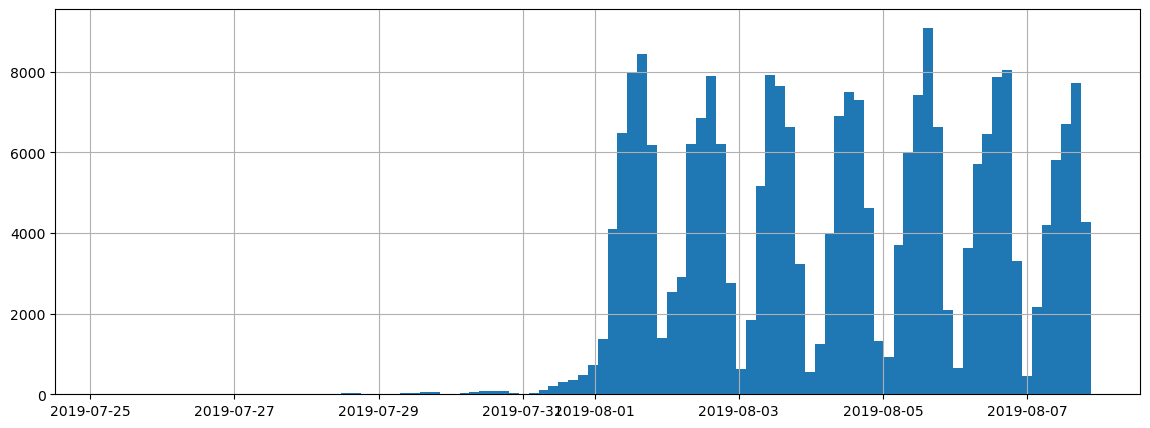

In [14]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
data['date_time'].hist(bins = 100, figsize=(14,5))

didapati di dataframe bahwa sebelum tanggal 2019-07-31 data yang dimiliki sangat sedikit sekali, dengan penemuan ini maka data yang akan dijadikan penelitian adalah sesudah pada tanggal tersebut

#### Periode mana yang benar-benar diwakili oleh data yang kamu miliki? <a id='442'></a>

In [15]:
# membuang data sebelum tanggal 2019-07-31
data.query('date > "2019-07-31"' , inplace = True)
data.sort_values(by='date', ascending= False).head()


,event,user,timestamp,exp_id,date_time,date
244125,OffersScreenAppear,5746969938801999050,1565212517,246,2019-08-07 21:15:17,2019-08-07
223377,MainScreenAppear,8557624836103102171,1565172881,246,2019-08-07 10:14:41,2019-08-07
223349,MainScreenAppear,6713384618608633696,1565172824,247,2019-08-07 10:13:44,2019-08-07
223350,MainScreenAppear,1599641448679221409,1565172826,247,2019-08-07 10:13:46,2019-08-07
223351,CartScreenAppear,6086359942961042433,1565172827,247,2019-08-07 10:13:47,2019-08-07


In [16]:
len(data)

240887

setelah datanya diiris terisa 240887 data dari 243713 data

<Axes: >

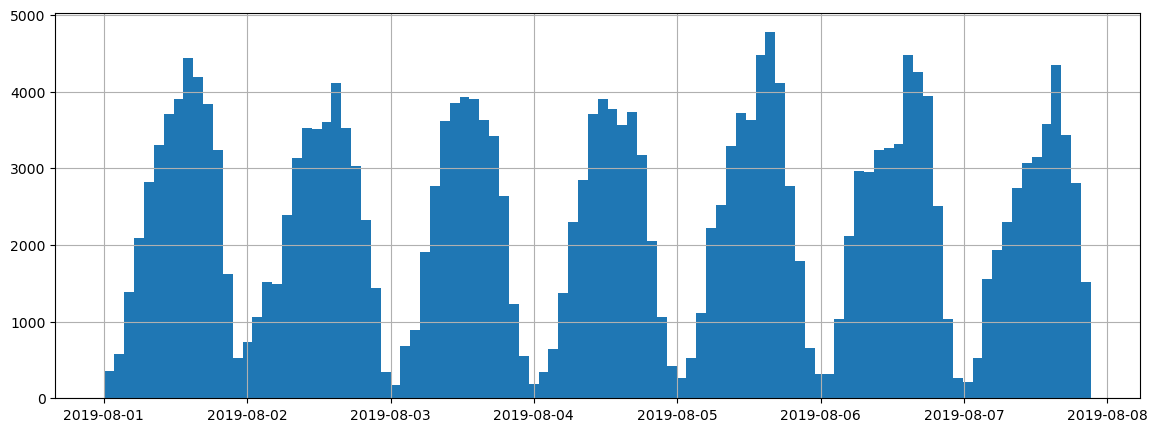

In [17]:
#histogram setelah data diiris
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
data['date_time'].hist(bins = 100, figsize=(14,5))

### Apakah kamu kehilangan banyak peristiwa dan pengguna saat menyingkirkan data lama? <a id='45'></a>

In [18]:
#data awal berjumlah 243713 data dan data sesudah diiris berjumlah 240887 data
243713 / 240887

1.0117316418071545

setelah datanya diiris, kita hanya kehilangan 1% data dari keseluruhan data yang dipunya

### Pastikan kamu memiliki pengguna dari ketiga kelompok eksperimen. <a id='46'></a>


In [19]:
data.exp_id.value_counts()

exp_id
248    84563
246    79302
247    77022
Name: count, dtype: int64

## Pelajari funnel peristiwanya <a id='5'></a>

### Peristiwa apa saja yang ada dalam log dan berapa banyak frekuensi kemunculannya <a id='51'></a>

In [20]:
data.head()

,event,user,timestamp,exp_id,date_time,date
2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01


In [22]:
data.pivot_table(
    index= 'event',
    values= 'user',
    columns='exp_id',
    aggfunc= 'count')

exp_id,246,247,248
event,,,
CartScreenAppear,14690,12434,15179
MainScreenAppear,37676,39090,40562
OffersScreenAppear,14767,15179,16387
PaymentScreenSuccessful,11852,9981,12085
Tutorial,317,338,350


In [26]:
data.pivot_table(
    index= 'event',
    values= 'user',
    aggfunc= 'count').sort_values(by='user', ascending=False)

,user
event,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


terdapat 5 event/peristiwa pada aplikasi yang kita punya, dan bagian tutorial sedikit sekali yang melihat. mungkin pengguna sudah familiar dengan aplikasi sejenis dengan yang kita punya jadi tidak perlu banyak adaptasi

### Temukan jumlah pengguna yang melakukan setiap tindakan. Urutkan peristiwa berdasarkan jumlah pengguna. Hitung proporsi pengguna yang melakukan tindakan setidaknya satu kali. <a id='52'></a>

In [27]:
users_per_event = data.pivot_table(
    index= 'event',
    values= 'user',
    aggfunc= lambda x: x.nunique()).sort_values(by='user', ascending=False)
users_per_event

,user
event,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [28]:
#konversi setiap event dari total pengguna
users_per_event / len(data['user'].unique())

,user
event,
MainScreenAppear,0.984736
OffersScreenAppear,0.609636
CartScreenAppear,0.495620
PaymentScreenSuccessful,0.469737
Tutorial,0.111495


pada tahap selanjutnya event tutorial tidak akan dihitung sebagai funnel utama dikarenakan tidak masuk akal jikalau sudah melakukan pembayaran baru melihat tutorial

### Gunakan funnel peristiwa untuk menemukan persentase pengguna yang terus berlanjut dari satu tahap ke tahap berikutnya <a id='53'></a>

In [52]:
#konversi event sesudah dengan event sebelumnya
users_funnel = users_per_event[:-1]
users_funnel = (users_funnel / users_funnel.shift())[1:]
users_funnel

,user
event,
OffersScreenAppear,0.619086
CartScreenAppear,0.812976
PaymentScreenSuccessful,0.947777


terdapat penurunan drastis dari main screen ke offers screen, sepertinya kita perlu membenahi main screen yang kita miliki agar pengguna tertarik melanjutkan ke offers screen

### Berapa banyak persentase pengguna yang berhasil menyelesaikan seluruh tahapan yang ada, dari peristiwa pertama hingga pembayaran? <a id='54'></a>

In [30]:
x= (users_per_event.loc['PaymentScreenSuccessful'] / users_per_event.loc['MainScreenAppear'] * 100)['user']
x
print(f"Persentase yang berhasil menyelesaikan seluruh tahapan adalah sebesar {x:.1f}%") 

Persentase yang berhasil menyelesaikan seluruh tahapan adalah sebesar 47.7%


## Pelajari hasil eksperimenmu <a id='6'></a>

### Berapa banyak pengguna yang ada di setiap kelompok? <a id='61'></a>


In [31]:
users_per_group = data.pivot_table(
    index= 'exp_id',
    values= 'user',
    aggfunc= lambda x: x.nunique())['user']
users_per_group

exp_id
246    2484
247    2513
248    2537
Name: user, dtype: int64

### Pilih peristiwa yang paling populer. Pada setiap kelompok kontrol, temukan jumlah pengguna yang melakukan tindakan tersebut <a id='62'></a>

In [32]:
users_event_per_group = data.pivot_table(
    index= 'event',
    values= 'user',
    columns= 'exp_id',
    aggfunc= lambda x: x.nunique())
users_event_per_group

exp_id,246,247,248
event,,,
CartScreenAppear,1266,1238,1230
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


event yang paling populer pada aplikasi ini adalah main screen appear, maka event ini akan digunakan pada pengecekan hipotesis selanjutnya

#### Periksa apakah perbedaan antar kelompok signifikan secara statistik. Ulangi prosedur ini untuk semua peristiwa lainnya <a id='621'></a>

In [33]:
# fungsi cek hipotesis 1event 2 kelompok
def check_hypothesis(succeses1, succeses2, trials1, trials2, alpha=0.05):
    #proporsi sukses di grup pertama
    p1 = succeses1 / trials1
    
    #proporsi sukses di grup kedua
    p2 = succeses2 / trials2
    
    #proporsi kombinasi
    p_combined = (succeses1 + succeses2) / (trials1 + trials2)
    
    #perbedaan proporsi
    difference= p1-p2
    
    #perhitungan statistik dengan normal deviasi di distribusi normal
    z_value= difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    #setting normal distribusi 
    distr = stats.norm(0,1)
    
    #perhitungan statistik dengan normal deviasi di distribusi normal
    z_value= difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    
    p_value = (1 - distr.cdf(abs(z_value))) *2
    
    print('pvalue: ',p_value)
    
    if (p_value < alpha):
        print("Menolak Hipotesis 0, terdapat perbedaan signifikan diantara proporsi")
    else:
        print("Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi")
        
    

In [34]:
check_hypothesis(users_event_per_group.loc['MainScreenAppear', 246],
                 users_event_per_group.loc['MainScreenAppear', 247],
                 users_per_group.loc[246],
                 users_per_group.loc[247],
                )

pvalue:  0.7570597232046099
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi


tidak terdapat perbedaan yang signifikan diantara event main screen kelompok 246 dengan main screen kelompok 247

In [35]:
# fungsi cek hipotesis semua event di 2 kelompok
def check_event_hypothesis(users_event_per_group, users_per_group, event, exp1, exp2):
    frac1= users_event_per_group.loc[event, exp1] / users_per_group.loc[exp1]
    frac2= users_event_per_group.loc[event, exp2] / users_per_group.loc[exp2]    
    
    print(f' {frac1} dengan event {event} di grup {exp1}')
    print(f' {frac2} dengan event {event} di grup {exp2}')
    
    check_hypothesis(users_event_per_group.loc[event, exp1],
                 users_event_per_group.loc[event, exp2],
                 users_per_group.loc[exp1],
                 users_per_group.loc[exp2],
                )

In [36]:
# menguji hipotesis seluruh event pada kelompok kontrol (246,247)
for event in users_event_per_group.index:
        check_event_hypothesis(users_event_per_group, users_per_group, event, 246,247)
        print()


 0.5096618357487923 dengan event CartScreenAppear di grup 246
 0.4926382809391166 dengan event CartScreenAppear di grup 247
pvalue:  0.22883372237997213
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.9863123993558777 dengan event MainScreenAppear di grup 246
 0.9852765618782332 dengan event MainScreenAppear di grup 247
pvalue:  0.7570597232046099
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.6207729468599034 dengan event OffersScreenAppear di grup 246
 0.6048547552725826 dengan event OffersScreenAppear di grup 247
pvalue:  0.2480954578522181
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.4830917874396135 dengan event PaymentScreenSuccessful di grup 246
 0.46080382013529647 dengan event PaymentScreenSuccessful di grup 247
pvalue:  0.11456679313141849
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.11191626409017713 dengan eve

begitu juga dengan event lainnya, tidak terdapat perbedaan yang signifikan antara kelompok 246 dengan kelompok 247

### Lakukan hal yang sama untuk kelompok pengguna yang diperlihatkan versi font terbaru. Bandingkan hasilnya dengan masing-masing kelompok kontrol untuk setiap peristiwa secara terpisah. <a id='63'></a>

In [37]:
# menguji hipotesis seluruh event pada kelompok 246 dengan 248
for event in users_event_per_group.index:
        check_event_hypothesis(users_event_per_group, users_per_group, event, 246,248)
        print()

 0.5096618357487923 dengan event CartScreenAppear di grup 246
 0.48482459597950334 dengan event CartScreenAppear di grup 248
pvalue:  0.07842923237520116
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.9863123993558777 dengan event MainScreenAppear di grup 246
 0.9826566811194324 dengan event MainScreenAppear di grup 248
pvalue:  0.2949721933554552
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.6207729468599034 dengan event OffersScreenAppear di grup 246
 0.6034686637761135 dengan event OffersScreenAppear di grup 248
pvalue:  0.20836205402738917
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.4830917874396135 dengan event PaymentScreenSuccessful di grup 246
 0.46551044540796216 dengan event PaymentScreenSuccessful di grup 248
pvalue:  0.2122553275697796
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.11191626409017713 dengan ev

In [38]:
# menguji hipotesis seluruh event pada kelompok 247 dengan 248
for event in users_event_per_group.index:
        check_event_hypothesis(users_event_per_group, users_per_group, event, 247,248)
        print()

 0.4926382809391166 dengan event CartScreenAppear di grup 247
 0.48482459597950334 dengan event CartScreenAppear di grup 248
pvalue:  0.5786197879539783
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.9852765618782332 dengan event MainScreenAppear di grup 247
 0.9826566811194324 dengan event MainScreenAppear di grup 248
pvalue:  0.4587053616621515
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.6048547552725826 dengan event OffersScreenAppear di grup 247
 0.6034686637761135 dengan event OffersScreenAppear di grup 248
pvalue:  0.9197817830592261
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.46080382013529647 dengan event PaymentScreenSuccessful di grup 247
 0.46551044540796216 dengan event PaymentScreenSuccessful di grup 248
pvalue:  0.7373415053803964
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.11261440509351373 dengan eve

#### Bandingkan hasilnya dengan hasil gabungan untuk kelompok kontrol <a id='631'></a>

In [39]:
#menggabungkan jumlah orang yang melakukan setiap event pada kelompok 246 dan 247
users_event_per_group_control = users_event_per_group.copy()
users_event_per_group_control.loc[:, 247] += users_event_per_group_control.loc[:, 246]
users_event_per_group_control.drop(columns=246, inplace= True)
users_event_per_group_control

exp_id,247,248
event,,
CartScreenAppear,2504,1230
MainScreenAppear,4926,2493
OffersScreenAppear,3062,1531
PaymentScreenSuccessful,2358,1181
Tutorial,561,279


In [40]:
#menggabungkan jumlah orang pada kleompok 246 dan 247
users_per_group_control = users_per_group.copy()
users_per_group_control.loc[247] += users_per_group_control.loc[246]
users_per_group_control.drop(index=246, inplace= True)
users_per_group_control

exp_id
247    4997
248    2537
Name: user, dtype: int64

In [41]:
for event in users_event_per_group_control.index:
        check_event_hypothesis(users_event_per_group_control, users_per_group_control, event, 247,248)
        print()

 0.5011006603962378 dengan event CartScreenAppear di grup 247
 0.48482459597950334 dengan event CartScreenAppear di grup 248
pvalue:  0.18175875284404386
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.9857914748849309 dengan event MainScreenAppear di grup 247
 0.9826566811194324 dengan event MainScreenAppear di grup 248
pvalue:  0.29424526837179577
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.6127676605963578 dengan event OffersScreenAppear di grup 247
 0.6034686637761135 dengan event OffersScreenAppear di grup 248
pvalue:  0.43425549655188256
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.47188312987792674 dengan event PaymentScreenSuccessful di grup 247
 0.46551044540796216 dengan event PaymentScreenSuccessful di grup 248
pvalue:  0.6004294282308704
Gagal Menolak Hipotesis 0, tidak terdapat perbedaan yang signifikan antara proporsi

 0.11226736041624975 dengan 

# Kesimpulan <a id='end'></a>

Setelah dilakukan analisis terhadap data yang kita punya, kita bisa menyimpulkan bahwa aplikasi yang dimiliki memiliki funnel penjualan yaitu event MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful. Sedangkan event Tutorial tidak masuk ke funnel penjualan, bahkan pengguna yang mengunjungi event ini sangat sedikit sekali, bisa diartikan bahwa aplikasi penjualan ini terbilang familiar dengan para pengguna.

Tetapi pada aplikasi ini kita kehilangan banyak pengguna pada saat peralihan antara MainScreen dengan OffersScreen, hanya sekitar 61,9% pengguna yang melanjutkan ke OffersScreen, Tim web designer harus mencari tahu ada masalah apa di MainScreen aplikasi ini, apakah terdapat adanya bug atau tampilan dari MainScreen ini kurang menarik perhatian pengguna sehingga tidak melanjutkan ke tahapan selanjutnya. Alhasil kita hanya mendapatkan persentase sebesar 47.7% pelanggan yang sampai ke PaymentScreenSuccessful dari pelanggan yang ada di event pertama (MainScreen)

Beralih ke hasil pengujian A/A/B Testing, didapat hasil bahwa merubah keseluruhan font pada aplikasi tidak begitu berpengaruh terhadap konversi dari pengujian antara kelompok uji dengan kelompok kontrol. Dengan adanya penemuan ini product manager seharusnya tidak perlu khawatir terhadap pelanggan yang justru merasa terganggu jikalau font dari aplikasi ini diubah.